# Periodic homogenization of linear elasticity {far}`star`

Objectives  
This tour will show how to perform periodic homogenization of linear elastic heterogeneous materials. In particular, we show how to define periodic boundary conditions and compute the effective stiffness tensor.

Attention  
This tour requires the `dolfinx_mpc` add-on package to enforce periodic boundary conditions. More details and installation instructions are to be found here https://github.com/jorgensd/dolfinx_mpc.

Download sources
* {Download}`Python script<./periodic_elasticity.py>`
* {Download}`Jupyter notebook<./periodic_elasticity.ipynb>`

The considered 2D plane strain problem deals with a skewed unit cell of dimensions $1\times \sqrt{3}/2$ consisting of circular inclusions (numbered `2`) of radius $R$ with elastic properties $(E_r, \nu_r)$ and embedded in a matrix material (numbered `1`) of properties $(E_m, \nu_m)$ following an hexagonal pattern. A classical result of homogenization theory ensures that the resulting overall behavior will be isotropic, a property that will be numerically verified later.

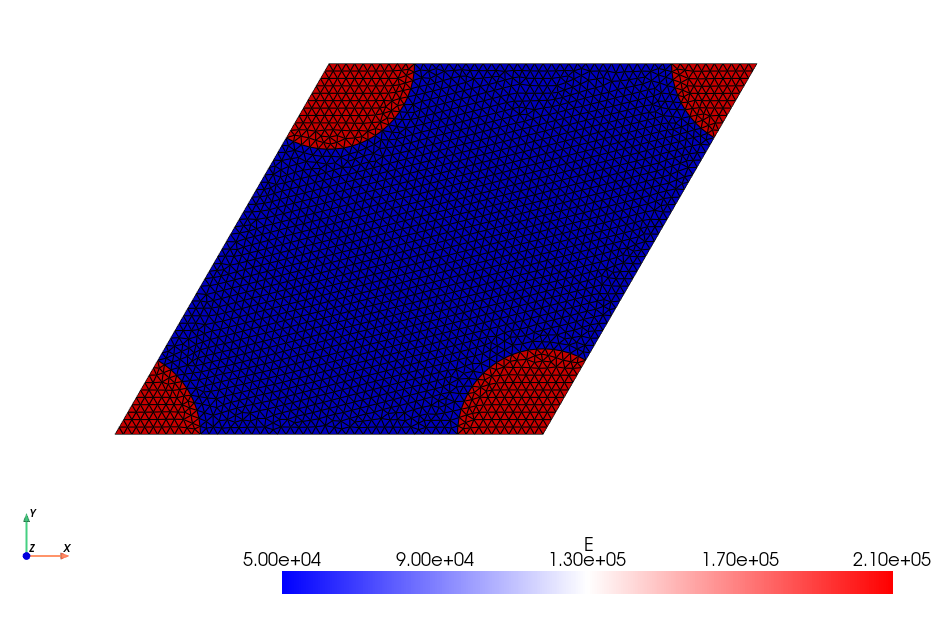

## Periodic homogenization framework

The goal of homogenization theory consists in computing the apparent elastic moduli of the homogenized medium associated with a given microstructure. In a linear elastic setting, this amounts to solving the following auxiliary problem defined on the unit cell $\mathcal{A}$:

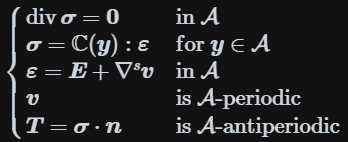

where $\boldsymbol{E}$ is the **given** macroscopic strain, $\boldsymbol{v}$ a periodic fluctuation and $\mathbb{C}(\boldsymbol{y})$ is the heterogeneous elasticity tensor depending on the microscopic space variable $\boldsymbol{y}\in\mathcal{A}$. By construction, the local microscopic strain is equal on average to the macroscopic strain: $\langle \boldsymbol{\varepsilon} \rangle = \boldsymbol{E}$. Upon defining the macroscopic stress $\boldsymbol{\Sigma}$ as the microscopic stress average: $\langle \boldsymbol{\sigma} \rangle = \boldsymbol{\Sigma}$, there will be a linear relationship between the auxiliary problem loading parameters $\boldsymbol{E}$ and the resulting average stress:

$$\boldsymbol{\Sigma}  = \mathbb{C}^\text{hom}:\boldsymbol{E}$$

where $\mathbb{C}^\text{hom}$ represents the apparent elastic moduli of the homogenized medium. Hence, its components can be computed by solving elementary load cases corresponding to the different components of $\boldsymbol{E}$ and performing a unit cell average of the resulting microscopic stress components.

### Total displacement as the main unknown

The previous problem can also be reformulated by using the total displacement $\boldsymbol{u} = \boldsymbol{E}\cdot\boldsymbol{y} + \boldsymbol{v}$ as the main unknown with now $\boldsymbol{\varepsilon} = \nabla^s \boldsymbol{u}$. The periodicity condition is therefore equivalent to the following constraint:

$$\boldsymbol{u}(\boldsymbol{y}^+)-\boldsymbol{u}(\boldsymbol{y}^-) = \boldsymbol{E}\cdot(\boldsymbol{y}^+-\boldsymbol{y}^-)$$

where $\boldsymbol{y}^{\pm}$ are opposite points on the unit cell boundary related by the periodicity condition. This formulation is widely used in solid mechanics FE software as it does not require specific change of the problem formulation but just adding tying constraints between some degrees of freedom.

This formulation is however not the easiest to deal with in `dolfinx_mpc`.

### Periodic fluctuation as the main unknown

Instead, we will keep the initial formulation and consider the periodic fluctuation $\boldsymbol{v}$ as the main unknown. The periodicity constraint on $\boldsymbol{v}$ will be imposed using the `create_periodic_constraint` functions of `dolfinx_mpc`. To do so, one must define the periodic map linking the different unit cell boundaries i.e. the right part is mapped onto the left part, the top part onto the bottom part.

## Implementation

### Mesh generation

Unit cell은 2D이며 경계는 평행사변형의 꼭짓점인 ``corners`` 를 사용하여 표현된다. `a1`, `a2` 벡터는 Y-periodic한 기준 방향을 의미한다. 우변은 좌변과 periodic constraint되어있고 윗변은 아랫변과 periodic constraint되어있다. 그리고 좌측 아래 꼭짓점은 우측 위 꼭짓점과 periodic constraint되어있다.

In [1]:
all = [var for var in globals() if var[0] != '_']
for var in all:
    del globals()[var]
del var, all

In [ ]:
import numpy as np
from mpi4py import MPI
import gmsh

import ufl
from dolfinx import fem, io
import dolfinx.fem.petsc
from dolfinx.io.gmsh import model_to_mesh
import dolfinx_mpc.utils
from dolfinx_mpc import LinearProblem

import pyvista
from dolfinx import plot

In [ ]:
### -------------------------------------------------- gmsh에서의 geometry 생성을 위한 파라미터 설정
Lx = 1.0 # RVE x 방향 길이
Ly = np.sqrt(3) / 2.0 * Lx # RVE y 방향 길이
c = 0.5 * Lx # RVE 윗변 시작점 x 좌표(RVE 윗변은 RVE 아랫변보다 c 만큼 오른쪽으로 이동)
R = 0.2 * Lx # RVE 안의 네 꼭짓점에 위치한 원의 반지름
h = 0.02 * Lx # 메쉬 크기

corners = np.array([[0.0, 0.0], [Lx, 0.0], [Lx + c, Ly], [c, Ly]]) # RVE의 네 꼭짓점 좌표 (2 x 4 배열)
a1 = corners[1, :] - corners[0, :]  # first vector generating periodicity
a2 = corners[3, :] - corners[0, :]  # second vector generating periodicity

지오미트리는 `gmsh`의 Python API 및 Open Cascade kernel를 사용하여 생성한다. RVE 내 matrix에 해당하는 영역은 tag `1`,  inclusions에 해당하는 영역은 tag `2`를 부여한다. RVE의 4개 변(하변/우변/상변/좌변)은 각각`1, 2, 3, 4`로 tag된다.


In [ ]:
### -------------------------------------------------- Gmsh 모델 생성 및 메쉬 생성 및 dolfinx로 변환

gdim = 2  # domain geometry dimension ... 2D
fdim = 1  # facets(boundary) geometry dimension ... 1D
gmsh.initialize()

occ = gmsh.model.occ
mesh_comm = MPI.COMM_WORLD # gmsh에서 생성한 메쉬를 dolfinx로 넘겨줄 때 mesh를 분산처리하기 위한 MPI 커뮤니케이터
model_rank = 0 # rank of the process responsible for building the Gmsh model (only one process should build the model to avoid conflicts)
if model_rank == 0:
    points = [occ.add_point(*corner, 0) for corner in corners] # RVE의 네 꼭짓점에 해당하는 점을 Gmsh 모델에 추가
    lines = [occ.add_line(points[i], points[(i + 1) % 4]) for i in range(4)] # RVE의 네 꼭짓점을 연결하는 선을 Gmsh 모델에 추가
    loop = occ.add_curve_loop(lines) # RVE의 네 선으로 둘러쌓인 폐곡선 루프를 Gmsh 모델에 추가
    unit_cell = occ.add_plane_surface([loop]) # RVE의 외곽선을 따라 평면 표면을 Gmsh 모델에 추가
    inclusions = [occ.add_disk(*corner, 0, R, R) for corner in corners] # RVE의 네 꼭짓점에 위치한 원을 Gmsh 모델에 추가
    vol_dimTag = (gdim, unit_cell) # RVE의 평면 표면에 대한 Gmsh 모델의 dimension-tag 쌍
    intersect_out = occ.intersect(
        [vol_dimTag], [(gdim, incl) for incl in inclusions], removeObject=False
    ) # 평행사변형 모양의 RVE domain과 네 개의 원이 겹치는 영역에 대해 dimension-tag 쌍을 생성(4개)
    incl_dimTags = intersect_out[0] # RVE의 평면 표면과 네 개의 원의 교차로 생성된 새로운 dimension-tag 쌍들의 리스트
    occ.synchronize() # Gmsh 모델의 CAD 데이터 구조를 업데이트하여 새로 추가된 엔티티들이 모델에 반영되도록 함
    cut_out = occ.cut([vol_dimTag], incl_dimTags, removeTool=False) # 평행사변형 모양의 RVE의 domain에서 네 개의 원이 차지하는 부분을 제거하여 inclusions을 제외한 순수 matrix domain을 생성
    occ.synchronize() # Gmsh 모델의 CAD 데이터 구조를 업데이트하여 차집합 연산으로 생성된 새로운 엔티티들이 모델에 반영되도록 함

    # tag physical domains and facets
    gmsh.model.addPhysicalGroup(gdim, [vol_dimTag[1]], 1, name="Matrix") # Matrix domain(1개 geometry)에 대한 surface physical group 1을 Gmsh 모델에 추가
    gmsh.model.addPhysicalGroup(
        gdim,
        [tag for _, tag in incl_dimTags],
        2,
        name="Inclusions",
    ) # Inclusions domain(4개 geometry)에 대한 surface physical group 2를 Gmsh 모델에 추가
    gmsh.model.addPhysicalGroup(fdim, [7, 20, 10], 1, name="bottom") # RVE 아랫변에 해당하는 선들(3개 geometry)에 대한 line physical group 1을 Gmsh 모델에 추가
    gmsh.model.addPhysicalGroup(fdim, [9, 19, 16], 2, name="right") # RVE 오른쪽 변에 해당하는 선들(3개 geometry)에 대한 line physical group 2를 Gmsh 모델에 추가
    gmsh.model.addPhysicalGroup(fdim, [15, 18, 12], 3, name="top") # RVE 윗변에 해당하는 선들(3개 geometry)에 대한 line physical group 3을 Gmsh 모델에 추가
    gmsh.model.addPhysicalGroup(fdim, [11, 17, 5], 4, name="left") # RVE 왼쪽 변에 해당하는 선들(3개 geometry)에 대한 line physical group 4를 Gmsh 모델에 추가
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", h) # Gmsh 모델의 모든 엔티티에 대해 최소 요소 크기를 h로 설정
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h) # Gmsh 모델의 모든 엔티티에 대해 최대 요소 크기를 h로 설정

    gmsh.model.mesh.generate(gdim) # Gmsh 모델의 geometry에 대해 gdim 차원의 요소로 구성된 메쉬를 생성

# gmsh에서 만든 메쉬 정보를 dolfinx로 변환하여 domain, cells, facets 객체를 생성. 자동으로 메쉬를 분산처리하여 각 rank에 domain, cells, facets 객체를 생성
# domain : Mesh 객체 / cells : MeshTags 객체 (domain과 같은 차원의 element마다 부여된) / facets : MeshTags 객체 (domain보다 한 차원 아래 차원의 객체에 부여된)
# 자동으로 physical group tag가 부여된 elements들만 dolfinx로 넘겨짐. physical group tag가 부여되지 않은 나머지 elements들은 dolfinx로 넘겨지지 않음.
mesh, tag_cell, tag_facet, *_ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
domain = mesh
cells = tag_cell
facets = tag_facet

gmsh.finalize()

Info    : Meshing 1D...ence                                                                                                                      
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Ellipse)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Ellipse)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Ellipse)
Info    : [ 60%] Meshing curve 14 (Ellipse)
Info    : [ 70%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 80%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [ 90%] Meshing curve 19 (Line)
Info    : [100%] Meshing curve 20 (Line)
Info    : Done meshing 1D (Wall 0.00090158s, CPU 0.000503s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Fro

/tmp/ipykernel_300340/1011137893.py:11: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show() # 플로터 표시


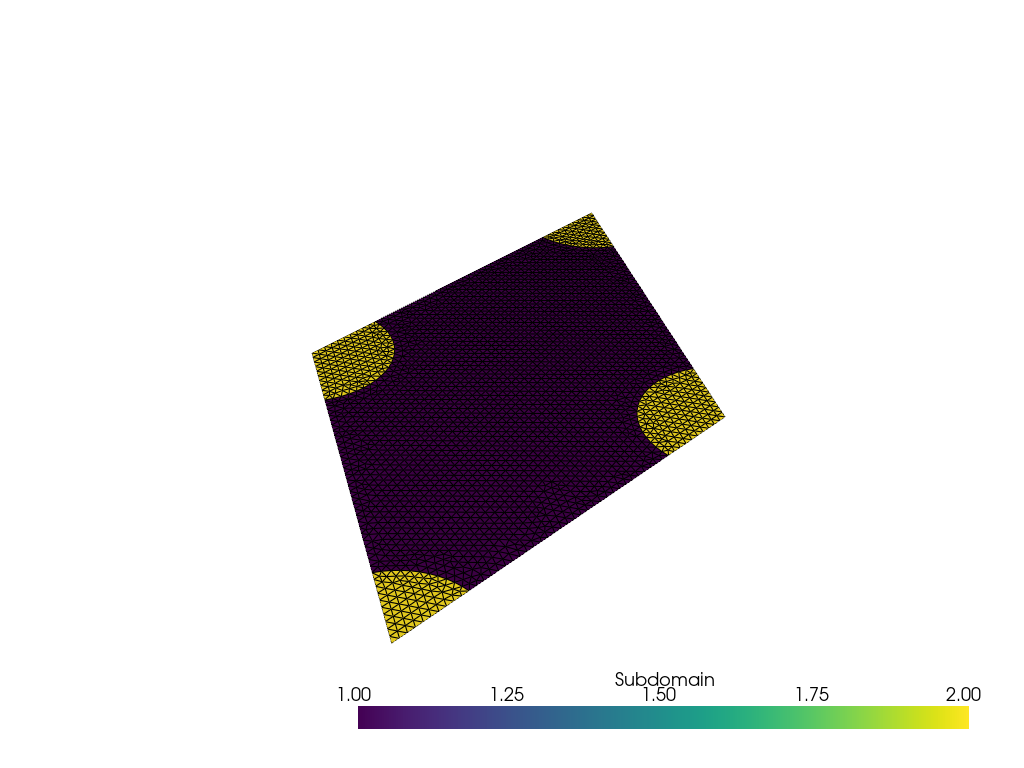

In [12]:
# 로컬 rank에서만 시각화
if mesh_comm.rank == 0:
    topology, cell_types, geometry = plot.vtk_mesh(domain) # domain 메쉬 객체를 pyvista에서 사용할 수 있는 형식으로 변환
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry) # pyvista UnstructuredGrid 객체 생성

    cell_tags = cells.values # 각각의 element가 속한 physical group의 tag 정보가 담긴 배열
    grid.cell_data["Subdomain"] = cell_tags # pyvista UnstructuredGrid 객체의 cell_data에 physical group tag 정보를 "Subdomain"이라는 이름으로 추가
    
    pl = pyvista.Plotter(notebook=True) # pyvista 플로터 객체 생성
    pl.add_mesh(grid, show_edges=True) # 메쉬를 플로터에 추가
    pl.show() # 플로터 표시

We compute the unit cell volume from the mesh for verification:

In [13]:
vol = fem.assemble_scalar(fem.form(1 * ufl.dx(domain=domain))) # domain의 전체 면적(체적)을 계산하기 위해 도메인 전체에 대해 1을 적분하는 형태로 표현된 ufl form을 dolfinx의 fem.assemble_scalar 함수를 사용하여 계산
print("Volume:", vol)

Volume: 0.8660254037844408


### Variational formulation with heterogeneous material properties
예전 버전 예제[legacy demo](https://comet-fenics.readthedocs.io/en/latest/demo/periodic_homog_elas/periodic_homog_elas.html)에서는 phase(즉 이종물질 간 구분되는 물질의 상)마다 적분영역을 나눠서 서로 다른 phase에 해당하는 적분영역에 서로 다른 material properties를 부여하고 weak form 문제 또한 적분영역을 나눠서(`dx(1)`과 `dx(2)`) variational formulation을 표현하게 만들었음. 그러나 해당 방법은 이종물질(즉 phase)의 수가 너무 많아지면 일일이 control해야 하기에 비효율적이 됨. 따라서 이 예제에서는 domain 내 임의 위치에 있는 cell(element)에 대해 이 cell이 속한 physical group tag에 대응되는 material properties를 부여하게끔 할 거임. 이를 위해 piecewise constant 함수인 (`DG0`) 함수를 각각 matrix와 inclusion phase에 사용할 거임. 이를 간단하게 표현하기 위해 dictionary의 label to value mapping 기능을 활용한 `create_piecewise_constant_field`라는 helper function을 새로 정의해서 `DG0` 함수를 생성할 거임(자세한 원리는 /tips/piecewise_constant_field/piecewise_constant_field.md 를 참고하셈). 이러한 식의 helper function은 손쉽게 vector 또는 tensor 형태의 함수로도 일반화하여 확장 사용할 수 있음.

In [ ]:
### -------------------------------------------------- domain의 각 요소가 속한 physical group tag에 따라 서로 다른 물성 상수를 부여하는 DG-0 함수 생성
def create_piecewise_constant_field(domain, cell_markers, property_dict, name=None):
    """Create a piecewise constant field with different values per subdomain.

    Parameters
    ----------
    domain : dolfinx에 생성된 Mesh 객체
    cell_markers : dolfinx에 생성된 MeshTags 객체
    property_dict : MeshTags에 들어있는 tag 넘버링에 대응되는 물리량을 mapping하여 속성을 부여할 딕셔너리

    Returns
    -------
    A DG-0 function
    """
    V0 = fem.functionspace(domain, ("DG", 0)) # Discontinuous Galerkin 0차 함수 공간 정의. DG는 CG와 다르게 DOFwise가 아니라 elementwise하게 대응된다. 일반적으로 FEM에서 쓰이는 연속함수 형태의 함수 공간과 달리 불연속을 허용하는 함수 공간
    k = fem.Function(V0, name=name) # DG-0 함수 공간에서 정의된 함수 객체 생성. 이 함수는 각 DOF가 아니라 요소마다 상수 값을 가짐. 따라서 함수 공간 k는 요소마다 하나의 DOF를 가지게 됨
    for tag, value in property_dict.items():
        cells = cell_markers.find(tag) # cell_markers에서 MeshTags = tag에 해당하는 요소들의 global index 배열을 반환
        k.x.array[cells] = np.full_like(cells, value, dtype=np.float64) # 함수 공간 k에서 cell_markers의 MeshTags = tag에 해당하는 요소들의 global index 배열인 cells에 대응되는 DOF들에 value 값을 할당.
    return k # 이 함수는 domain의 각 요소가 속한 physical group tag에 따라 property_dict에서 정의된 물리량을 요소마다 상수로 가지는 DG-0 함수를 생성하여 반환

# domain의 각 요소가 속한 physical group tag에 따라 Young's modulus와 Poisson's ratio를 요소마다 상수로 가지는 DG-0 함수 생성
E = create_piecewise_constant_field(
    domain, cells, {1: 50e3, 2: 210e3}, name="YoungModulus"
)
nu = create_piecewise_constant_field(
    domain, cells, {1: 0.2, 2: 0.3}, name="PoissonRatio"
)

# E 함수와 nu 함수를 이용하여 Lame 상수 lambda와 mu를 요소마다 상수로 가지는 DG-0 함수 생성
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2 / (1 + nu)

As discussed before, our main unknown is the periodic fluctuation `v`. The loading will be imposed by the macroscopic strain `E` which we define as a `fem.Constant`. We will then be able to rebuild the total displacement `u = E*y + v` using the `ufl.SpatialCoordinate`. Below we define the variational form. Note that `ufl.inner(sigma(du), epsilon(u_)) * ufl.dx` contains both bilinear and linear terms, the latter being due to the presence of the macroscopic strain `E` acting as an external loading. We make use of `ufl.system` to split the form into a bilinear and linear form.  

-- -- -- -- -- -- -- -- - --- -- - - - -- - - --- -- -- -- -- -- -- -- - --- -- - - - -- - - --- -- -- -- -- -- -- -- - --- -- - - - -- - - --- -- -- -- -- -- -- -- - --- -- - - - -- - - --- -- 
<해석>  
우리가 구하고자 하는 건 microscale에서 움직이는 fluctuation displacement `v`임. 그리고 일종의 source term으로 macroscale strain `E` 가 `fem.Constant`로 가해질 거임. 그리고 나서 문제 풀어서 v를 구하면 `u = Ey + v`로 macroscale displacement u를 구할 수 있음(이를 위해 `y = ufl.SpatialCoordinate`라는 객체를 쓸 거임). 일단 weak form 구성을 위해  
1. 해함수인 v를 구하기 위한 함수 공간 V를 생성
2. 해함수(trial function) `du` 생성
3. 시험함수(test function) `u_` 생성
4. bilinear form, linear form 형태의 weak form term들 생성  
※ 이 때 `ufl.system` 함수 사용하면 알잘딱깔센으로 test function이랑 trial function을 분간해서 부분적분 및 divergence theorem 시전한 식 형태로 좌변 우변으로 항 찢어서 보내줌  
그게 `a_form`, `L_form` 임

In [ ]:
### -------------------------------------------------- weak form 구성을 위한 사전 준비
Eps = fem.Constant(domain, np.zeros((2, 2))) # unit initial strain tensor로 초기응력 텐서 계산에 사용.
Eps_ = fem.Constant(domain, np.zeros((2, 2))) # 지금 쓰이는 애는 아니고, 후반부에 문제 다 풀고 나서 effective property 계산할 때 쓸 예정
y = ufl.SpatialCoordinate(domain)


def epsilon(v): # 변형률 텐서 ; 얘는 test function에 대한 함수
    return ufl.sym(ufl.grad(v))

def sigma(v): # 초기응력 텐서 ; 얘는 trial function에 대한 함수
    eps = Eps + epsilon(v)
    return lmbda * ufl.tr(eps) * ufl.Identity(gdim) + 2 * mu * eps # 초기 변형률로 인한 초기 응력. ufl.Identity(gdim)은 gdim x gdim 단위 행렬을 생성

V = fem.functionspace(domain, ("P", 2, (gdim,))) # 2차 Lagrange 벡터 함수 공간 정의. ("P", 2)는 2차 Lagrange 요소를 사용하여 스칼라 함수를 표현하는 함수 공간을 정의하는 것을 의미. (gdim,)은 이 스칼라 함수 공간을 gdim 차원의 벡터 함수 공간으로 확장하여 각 노드에서 gdim 개의 DOF를 가지도록 하는 것을 의미. 따라서 V는 2차 Lagrange 벡터 함수 공간이 됨.
du = ufl.TrialFunction(V) # trial function 생성
u_ = ufl.TestFunction(V) # test function 생성
a_form, L_form = ufl.system(ufl.inner(sigma(du), epsilon(u_)) * ufl.dx) 
# 그 웬만하면 그냥 내가 직접 a_form이랑 L_form 만들어서 LinearProblem에 넣는 걸로 하자.
# ufl.system은 coupled된 형태의 a_form과 L_form을 자동으로 분리해주는 편리한 함수이긴 하지만, 지금처럼 완전히 decoupled된 경우에는 오히려 혼란을 줄 수 있을 것 같음.

### Periodic boundary conditions enforcement using `dolfinx_mpc`

We must now define the periodic boundary conditions for the fluctuation field. For that, we make use of `dolfinx_mpc` providing a `MultiPointConstraint` object which can account for periodicity conditions. Note that periodic conditions do not fix rigid body translations. To remove them we choose here, for simplicity, to fix the displacement of the single point of coordinate `(0, 0)`. An alternative can consist of introducing constant Lagrange multipliers as discussed in the legacy demo. This solution requires however to use `Real` elements which require special care and are currently available in the `scifem` package https://github.com/scientificcomputing/scifem.
- - - - - - - - - - - - - - - -- - - - - - - -- - - - - - - -- - - - - - - -
<해석>  
이제 주기 경계조건을 fluctuation displacement field에 줘보자. 이를 위해 `dolfinx_mpc` 라이브러리에서 제공하는 `MultiPointConstraint` 객체를 사용해야 한다. 참고로 주기 조건만 주면은 강체 운동을 막을 수 없다는 걸 기억하자. 강체 운동을 막으려면 반드시 Dirichelt 구속 조건을 어딘가에 줘야 하고 이 문제에서는 (0, 0) 점에 줄 거다.

In [ ]:
### --------------------------------  먼저 (0, 0) 점에 fixed BC를 부여. 이 BC는 해의 유일성을 보장하기 위해 필요함.

# V 함수 공간에서 (0, 0) 점에 해당하는 DOF의 global index 배열을 반환. 
# locate_dofs_geometrical 함수는 주어진 기하학적 조건을 만족하는 점에 해당하는 DOF를 찾는 함수. 
# 여기서는 lambda 함수를 사용하여 x 좌표가 0에 가깝고 y 좌표가 0에 가까운 점에 해당하는 DOF를 찾도록 지정 ... numerical precision으로 인해 이렇게 접근
point_dof = fem.locate_dofs_geometrical(
    V, lambda x: np.isclose(x[0], 0.0) & np.isclose(x[1], 0)
) 

# 위에서 찾은 (0, 0) 점의 DOF에 fixed BC를 부여. 
bcs = [fem.dirichletbc(np.zeros((gdim,)), point_dof, V)] 

We first instantiate the `MultiPointConstraint` object `mpc` defined with respect to our function space `V`. The function `create_periodic_constraint_topological` enables to link dofs on corresponding surfaces. We must first define a mapping between points on corresponding surfaces. For instance, we apply the first condition to the right surface, tagged `2`. The `periodic_relation_left_right` transforms input coordinates on the right surface to points on the left surface as follows: $(x, y) \mapsto (x-L_x, y)$. More generally, the mapping is $(x, y) \mapsto (x-a_{1x}, y-a_{1y})$ for the first periodicity-generating base vector $\ba_1$. We do the same for the top surface, tagged `3`, which is mapped to th
e bottom one using the second periodicity-generating base vector $\ba_2.$

In [ ]:
def periodic_relation_left_right(x):
    out_x = np.zeros(x.shape)
    out_x[0] = x[0] - a1[0]
    out_x[1] = x[1] - a1[1]
    out_x[2] = x[2]
    return out_x


def periodic_relation_bottom_top(x):
    out_x = np.zeros(x.shape)
    out_x[0] = x[0] - a2[0]
    out_x[1] = x[1] - a2[1]
    out_x[2] = x[2]
    return out_x


mpc = dolfinx_mpc.MultiPointConstraint(V)
mpc.create_periodic_constraint_topological(
    V, facets, 2, periodic_relation_left_right, bcs
)
mpc.create_periodic_constraint_topological(
    V, facets, 3, periodic_relation_bottom_top, bcs
)
mpc.finalize()

### Problem resolution

We are now in position of defining the problem instance. Note that we must use here the `LinearProblem` provided by `dolfinx_mpc` and not that of `dolfinx.fem.petsc`. The former expands upon the latter by including the `MultiPointConstraint` object in its arguments. Note also that the solution function field $\bv$, and the related total displacement $\bu$, must be built from the reduced function space object provided by `mpc.function_space` and not `V` in order to properly account for the imposed kinematic constraint.

In [ ]:
u = fem.Function(mpc.function_space, name="Displacement")
v = fem.Function(mpc.function_space, name="Periodic_fluctuation")
problem = LinearProblem(
    a_form,
    L_form,
    mpc,
    bcs=bcs,
    u=v,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
)

To solve the homogenization problem, we define a list of elementary load cases representing macroscopic uniaxial tension in both $x$ and $y$ directions and uniform macroscopic shear in the $xy$ direction. For each of such elementary load case, we update the value of the macroscopic strain constant $\bE$ and solve the corresponding problem. The microscopic total displacement $\bu(\by)$ is then built from the periodic fluctuation. For each load case, we compute the different components of the macroscopic average stress $\boldsymbol{\Sigma}$. Since we considered unit load cases, the latter directly provide the components of the macroscopic effective stiffness tensor $\mathbb{C}^\text{hom}$.

In [ ]:
import pyvista
from dolfinx import plot

pyvista.set_jupyter_backend("static")


def plot_warped(u, scale=1.0, plot_mesh=False, user_callback=None, title=None):
    Vu = u.function_space
    u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vu)
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
    u_3D = np.zeros((u_geometry.shape[0], 3))
    u_3D[:, :2] = u.x.array.reshape(-1, 2)
    u_grid.point_data[u.name] = u_3D
    u_grid.set_active_vectors(u.name)
    warped = u_grid.warp_by_vector(u.name, factor=scale)

    plotter = pyvista.Plotter()
    plotter.window_size = (800, 300)
    plotter.add_mesh(warped)
    if plot_mesh:
        edges = warped.extract_all_edges()
        plotter.add_mesh(edges, color="k", line_width=1, opacity=0.5)
    plotter.view_xy()
    if title:
        plotter.add_text(title, font_size=14)
    plotter.show()

In [ ]:
elementary_load = [
    np.array([[1.0, 0.0], [0.0, 0.0]]),
    np.array([[0.0, 0.0], [0.0, 1.0]]),
    np.array([[0.0, 0.5], [0.5, 0.0]]),
]
load_labels = ["Exx", "Eyy", "Exy"]
dim_load = len(elementary_load)

C_hom = np.zeros((dim_load, dim_load))
for nload in range(dim_load):
    Eps.value = elementary_load[nload]
    u.interpolate(
        fem.Expression(
            ufl.dot(Eps, y), mpc.function_space.element.interpolation_points()
        )
    )

    problem.solve()
    u.x.array[:] += v.x.array[:]

    plot_warped(u, scale=0.5, plot_mesh=True, title=load_labels[nload])

    for nload_ in range(dim_load):
        Eps_.value = elementary_load[nload_]

        C_hom[nload, nload_] = (
            fem.assemble_scalar(fem.form(ufl.inner(sigma(v), Eps_) * ufl.dx)) / vol
        )

### Effective stiffness

In [ ]:
with np.printoptions(suppress=True, precision=0):
    print(C_hom)

It can first be verified that the obtained macroscopic stiffness is indeed symmetric and that the corresponding behavior is quasi-isotropic (up to the finite element discretization error). Indeed, if $\lambda^{hom} = \mathbb{C}_{xxyy}$ and $\mu^{hom} = \mathbb{C}_{xyxy}$ we have that $\mathbb{C}_{xxxx}\approx\mathbb{C}_{yyyy}\approx \mathbb{C}_{xxyy}+2\mathbb{C}_{xyxy} = \lambda^{hom}+2\mu^{hom}$.

In [ ]:
lmbda_hom = C_hom[0, 1]
mu_hom = C_hom[2, 2]
print("Isotropy check:", C_hom[0, 0], lmbda_hom + 2 * mu_hom)

```{note}
The macroscopic stiffness is not exactly symmetric because we computed it from the average stress which is not strictly verifying local equilibrium on the unit cell due to the FE discretization. A truly symmetric version can be obtained from the computation of the bilinear form for a pair of solutions to the elementary load cases.
```

We then deduce that $E^{hom} = \mu^{hom}\dfrac{3\lambda^{hom}+2\mu^{hom}}{\lambda^{hom}+\mu^{hom}}$ and $\nu^{hom} = \dfrac{\lambda^{hom}}{2(\lambda^{hom}+\mu^{hom})}$ that is:

In [ ]:
E_hom = mu_hom * (3 * lmbda_hom + 2 * mu_hom) / (lmbda_hom + mu_hom)
nu_hom = lmbda_hom / (lmbda_hom + mu_hom) / 2
print(f"Apparent Young modulus: {E_hom:.0f}")
print(f"Apparent Poisson ratio: {nu_hom:.3f}")